In [1]:
import numpy as np
import pandas as pd
from datetime import datetime 
from IPython.display import display, HTML

import shap
shap.initjs()

from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

X, Y = shap.datasets.adult()
sensitive_attribute = 'Sex'

A = X[sensitive_attribute]
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

X = X.reset_index(drop=True)
A = A.reset_index(drop=True)

X_train = pd.DataFrame(X)
A_train = pd.Series(A)
y_train = pd.Series(Y)

# Combine all training data into a single data frame and glance at a few rows
train_all = pd.concat([X_train, y_train, A_train], axis=1)

# Keep the complete dataset for grid search
X_train_all = X_train
y_train_all = y_train
A_train_all = A_train

In [2]:
# Subsampling process
fractions = [0.01,0.05,0.1,0.2,0.5,0.8,0.9,1]
#fractions = [0.01,0.05]
A_trains = []
X_trains = []
y_trains = []

for f in fractions: 
    subsampling = train_all.sample(frac=f)
    subsampling = subsampling.reset_index()
    subsampling = subsampling.drop(columns=['index'])
    tmp = subsampling.iloc[:, :-1]
    A_train = subsampling.iloc[:, -1]
    X_train = tmp.iloc[:, :-1]
    y_train = tmp.iloc[:,-1]
    A_trains.append(A_train)
    X_trains.append(X_train)
    y_trains.append(y_train)

In [3]:
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train_all, y_train_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [4]:
def get_error(y,predicted_y):
    correct_y = (y == predicted_y)
    return 1 - sum(correct_y)/len(correct_y)

def get_violation(predict_y,A_test,label_name):
    violations = []
    predicted_and_sensitiveFeature = pd.concat([predict_y,A_test],axis=1)
    grouped =predicted_and_sensitiveFeature.groupby('Sex')
    counts_by_race = grouped[[label_name]].count()
    passed_by_race = grouped[[label_name]].sum()

    for i,group in enumerate(grouped.groups.keys()):
        violation_1 = passed_by_race[label_name][i] / counts_by_race[label_name][i]
        violation_2 = sum(predict_y) / len(predict_y)
        violations.append(abs(violation_1 - violation_2))
    violation = max(violations)
    return violation

In [5]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity
import numpy as np

In [6]:
# Expgrad on full dataset
expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=0.01,
    nu=1e-6)

a=datetime.now()  
expgrad_X_logistic.fit(
X_train_all,
y_train_all,
sensitive_features=A_train_all)
b=datetime.now()
time_expgrad_all = (b-a).seconds

expgrad_y_logistic = pd.Series(expgrad_X_logistic.predict(X_train_all),name="logistic_learner_y")
error_expgrad_logistic_all = get_error(y_train_all,expgrad_y_logistic)
violation_expgrad_logistic_all = get_violation(expgrad_y_logistic,A_train_all,"logistic_learner_y")
# Variables
time_expgrad_fracs = []
time_expgrad_alls = []
time_grids = []

error_expgrad_fracs = []
error_expgrad_alls = []
error_grids = []

vio_expgrad_fracs = []
vio_expgrad_alls = []
vio_grids = []
# Iterations on difference fractions
for i,f in enumerate(fractions):
    time_expgrad_alls.append(time_expgrad_all)
    error_expgrad_alls.append(error_expgrad_logistic_all)
    vio_expgrad_alls.append(violation_expgrad_logistic_all)
    
    A_train = A_trains[i]
    X_train = X_trains[i]
    y_train = y_trains[i]
    
    # Expgrad on sub dataset
    expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=0.01,
    nu=1e-6)
    
    a=datetime.now()  
    expgrad_X_logistic.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    b=datetime.now()
    time_expgrad_frac = (b-a).seconds
    time_expgrad_fracs.append(time_expgrad_frac)
    
    expgrad_y_logistic = pd.Series(expgrad_X_logistic.predict(X_train_all),name="logistic_learner_y")
    error_expgrad_logistic = get_error(y_train_all,expgrad_y_logistic)
    violation_expgrad_logistic = get_violation(expgrad_y_logistic,A_train_all,"logistic_learner_y")
    
    error_expgrad_fracs.append(error_expgrad_logistic)
    vio_expgrad_fracs.append(violation_expgrad_logistic)
    
    # Grid Search part
    lambda_vecs_logistic = (expgrad_X_logistic._lambda_vecs_LP)
    keys = lambda_vecs_logistic.keys()
    lambda_vec_logistic = lambda_vecs_logistic[keys[-1]]
    
    grid_search_logistic=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid_offset=lambda_vec_logistic)
    a=datetime.now()  
    grid_search_logistic.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
    b=datetime.now()
    time_grid_search_logistic = (b-a).seconds
    time_grids.append(time_grid_search_logistic)
    
    grid_search_logistic_y = pd.Series(grid_search_logistic.predict(X_train_all),name="grid_search_logistic_y") 
    vio_grids.append(get_violation(grid_search_logistic_y,A_train_all,"grid_search_logistic_y"))
    error_grids.append(get_error(y_train_all,grid_search_logistic_y))
    

    

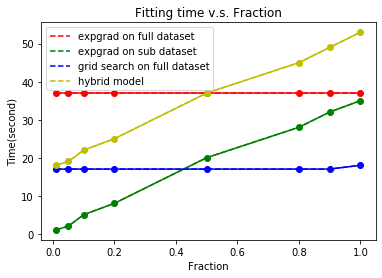

In [7]:
import matplotlib.pyplot as plt

time_hybrid = [time_grids[i] + time_expgrad_fracs[i] for i in range(len(fractions))]
l1 = plt.plot(fractions,time_expgrad_alls,'r--',label="expgrad on full dataset")
l2 = plt.plot(fractions,time_expgrad_fracs,'g--',label="expgrad on sub dataset")
l3 = plt.plot(fractions,time_grids,'b--',label="grid search on full dataset")
l4 = plt.plot(fractions,time_hybrid,'y--',label="hybrid model")
plt.plot(fractions,time_expgrad_alls,'ro-',fractions,time_expgrad_fracs,'go-',fractions,time_grids,'bo-',fractions,time_hybrid,'yo-')
plt.xlabel('Fraction')
plt.ylabel('Time(second)')
plt.title('Fitting time v.s. Fraction')
plt.legend()
plt.show()

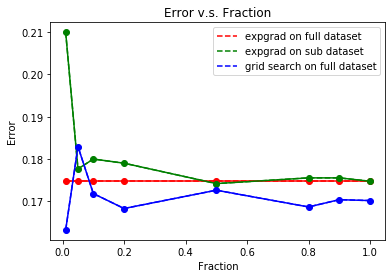

In [8]:
l1 = plt.plot(fractions,error_expgrad_alls,'r--',label="expgrad on full dataset")
l2 = plt.plot(fractions,error_expgrad_fracs,'g--',label="expgrad on sub dataset")
l3 = plt.plot(fractions,error_grids,'b--',label="grid search on full dataset")
plt.plot(fractions,error_expgrad_alls,'ro-',fractions,error_expgrad_fracs,'go-',fractions,error_grids,'bo-')
plt.xlabel('Fraction')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.legend()
plt.show()

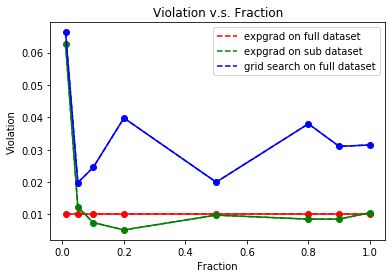

In [9]:
l1 = plt.plot(fractions,vio_expgrad_alls,'r--',label="expgrad on full dataset")
l2 = plt.plot(fractions,vio_expgrad_fracs,'g--',label="expgrad on sub dataset")
l3 = plt.plot(fractions,vio_grids,'b--',label="grid search on full dataset")
plt.plot(fractions,vio_expgrad_alls,'ro-',fractions,vio_expgrad_fracs,'go-',fractions,vio_grids,'bo-')
plt.xlabel('Fraction')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.legend()
plt.show()

# Using _lambda_vecs_lagrangian as offset

In [10]:
# Variables
time_expgrad_fracs = []
time_expgrad_alls = []
time_grids = []
time_hybrid = []

error_expgrad_fracs = []
error_expgrad_alls = []
error_grids = []

vio_expgrad_fracs = []
vio_expgrad_alls = []
vio_grids = []
# Iterations on difference fractions
for i,f in enumerate(fractions):
    time_expgrad_alls.append(time_expgrad_all)
    error_expgrad_alls.append(error_expgrad_logistic_all)
    vio_expgrad_alls.append(violation_expgrad_logistic_all)
    
    A_train = A_trains[i]
    X_train = X_trains[i]
    y_train = y_trains[i]
    
    # Expgrad on sub dataset
    expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=0.01,
    nu=1e-6)
    
    a=datetime.now()  
    expgrad_X_logistic.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    b=datetime.now()
    time_expgrad_frac = (b-a).seconds
    time_expgrad_fracs.append(time_expgrad_frac)
    
    expgrad_y_logistic = pd.Series(expgrad_X_logistic.predict(X_train_all),name="logistic_learner_y")
    error_expgrad_logistic = get_error(y_train_all,expgrad_y_logistic)
    violation_expgrad_logistic = get_violation(expgrad_y_logistic,A_train_all,"logistic_learner_y")
    
    error_expgrad_fracs.append(error_expgrad_logistic)
    vio_expgrad_fracs.append(violation_expgrad_logistic)
    
    # Grid Search part
    lambda_vecs_logistic = (expgrad_X_logistic._lambda_vecs_lagrangian)
    keys = lambda_vecs_logistic.keys()
    lambda_vec_logistic = lambda_vecs_logistic[keys[-1]]
    
    grid_search_logistic=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid_offset=lambda_vec_logistic)
    a=datetime.now()  
    grid_search_logistic.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
    b=datetime.now()
    time_grid_search_logistic = (b-a).seconds
    time_grids.append(time_grid_search_logistic)
    
    grid_search_logistic_y = pd.Series(grid_search_logistic.predict(X_train_all),name="grid_search_logistic_y") 
    vio_grids.append(get_violation(grid_search_logistic_y,A_train_all,"grid_search_logistic_y"))
    error_grids.append(get_error(y_train_all,grid_search_logistic_y))

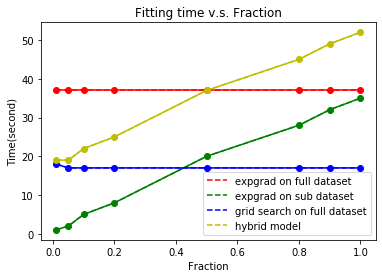

In [11]:
import matplotlib.pyplot as plt

time_hybrid = [time_grids[i] + time_expgrad_fracs[i] for i in range(len(fractions))]
l1 = plt.plot(fractions,time_expgrad_alls,'r--',label="expgrad on full dataset")
l2 = plt.plot(fractions,time_expgrad_fracs,'g--',label="expgrad on sub dataset")
l3 = plt.plot(fractions,time_grids,'b--',label="grid search on full dataset")
l4 = plt.plot(fractions,time_hybrid,'y--',label="hybrid model")
plt.plot(fractions,time_expgrad_alls,'ro-',fractions,time_expgrad_fracs,'go-',fractions,time_grids,'bo-',fractions,time_hybrid,'yo-')
plt.xlabel('Fraction')
plt.ylabel('Time(second)')
plt.title('Fitting time v.s. Fraction')
plt.legend()
plt.show()

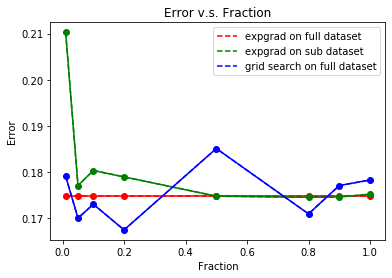

In [12]:
l1 = plt.plot(fractions,error_expgrad_alls,'r--',label="expgrad on full dataset")
l2 = plt.plot(fractions,error_expgrad_fracs,'g--',label="expgrad on sub dataset")
l3 = plt.plot(fractions,error_grids,'b--',label="grid search on full dataset")
plt.plot(fractions,error_expgrad_alls,'ro-',fractions,error_expgrad_fracs,'go-',fractions,error_grids,'bo-')
plt.xlabel('Fraction')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.legend()
plt.show()

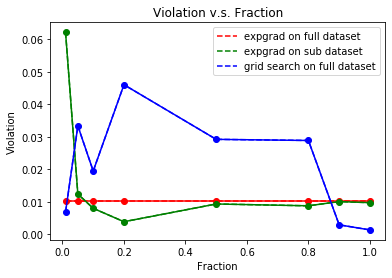

In [13]:
l1 = plt.plot(fractions,vio_expgrad_alls,'r--',label="expgrad on full dataset")
l2 = plt.plot(fractions,vio_expgrad_fracs,'g--',label="expgrad on sub dataset")
l3 = plt.plot(fractions,vio_grids,'b--',label="grid search on full dataset")
plt.plot(fractions,vio_expgrad_alls,'ro-',fractions,vio_expgrad_fracs,'go-',fractions,vio_grids,'bo-')
plt.xlabel('Fraction')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.legend()
plt.show()

# Generate grid as input

In [14]:
# Variables
time_expgrad_fracs = []
time_expgrad_alls = []
time_grids = []
time_hybrid = []

error_expgrad_fracs = []
error_expgrad_alls = []
error_grids = []

vio_expgrad_fracs = []
vio_expgrad_alls = []
vio_grids = []
# Iterations on difference fractions
for i,f in enumerate(fractions):
    time_expgrad_alls.append(time_expgrad_all)
    error_expgrad_alls.append(error_expgrad_logistic_all)
    vio_expgrad_alls.append(violation_expgrad_logistic_all)
    
    A_train = A_trains[i]
    X_train = X_trains[i]
    y_train = y_trains[i]
    
    # Expgrad on sub dataset
    expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=0.01,
    nu=1e-6)
    
    a=datetime.now()  
    expgrad_X_logistic.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    b=datetime.now()
    time_expgrad_frac = (b-a).seconds
    time_expgrad_fracs.append(time_expgrad_frac)
    
    expgrad_y_logistic = pd.Series(expgrad_X_logistic.predict(X_train_all),name="logistic_learner_y")
    error_expgrad_logistic = get_error(y_train_all,expgrad_y_logistic)
    violation_expgrad_logistic = get_violation(expgrad_y_logistic,A_train_all,"logistic_learner_y")
    
    error_expgrad_fracs.append(error_expgrad_logistic)
    vio_expgrad_fracs.append(violation_expgrad_logistic)
    
    # Grid Search part
    lambda_vecs_logistic = (expgrad_X_logistic._lambda_vecs_lagrangian)
    keys = lambda_vecs_logistic.keys()
    lambda_vec_logistic = lambda_vecs_logistic[keys[-1]]
    
    # Generate the grid
    lambda_0_logistic = lambda_vec_logistic['+','all',0] - lambda_vec_logistic['-','all',0]  
    scope = 0.2
    lambda_multipliers_logistic = np.linspace(lambda_0_logistic-scope, lambda_0_logistic+scope, 11)
    iterables = [['+', '-'], ['all'], [0,1]]
    midx = pd.MultiIndex.from_product(iterables, names=['sign', 'event', 'group_id'])
    new_lambdas = []
    for l in lambda_multipliers_logistic:
        nxt = pd.Series(np.zeros(4), index=midx)   
        if l < 0:
            nxt[("-", "all", 0)] = abs(l)
        else:
            nxt[("+", "all", 0)] = l

        new_lambdas.append(nxt)
    multiplier_df_logistic = pd.concat(new_lambdas,axis=1)
    # Fitting
    grid_search_logistic=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=multiplier_df_logistic)
    a=datetime.now()  
    grid_search_logistic.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
    b=datetime.now()
    time_grid_search_logistic = (b-a).seconds
    time_grids.append(time_grid_search_logistic)
    
    grid_search_logistic_y = pd.Series(grid_search_logistic.predict(X_train_all),name="grid_search_logistic_y") 
    vio_grids.append(get_violation(grid_search_logistic_y,A_train_all,"grid_search_logistic_y"))
    error_grids.append(get_error(y_train_all,grid_search_logistic_y))

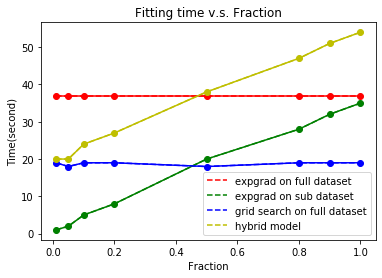

In [15]:
import matplotlib.pyplot as plt

time_hybrid = [time_grids[i] + time_expgrad_fracs[i] for i in range(len(fractions))]
l1 = plt.plot(fractions,time_expgrad_alls,'r--',label="expgrad on full dataset")
l2 = plt.plot(fractions,time_expgrad_fracs,'g--',label="expgrad on sub dataset")
l3 = plt.plot(fractions,time_grids,'b--',label="grid search on full dataset")
l4 = plt.plot(fractions,time_hybrid,'y--',label="hybrid model")
plt.plot(fractions,time_expgrad_alls,'ro-',fractions,time_expgrad_fracs,'go-',fractions,time_grids,'bo-',fractions,time_hybrid,'yo-')
plt.xlabel('Fraction')
plt.ylabel('Time(second)')
plt.title('Fitting time v.s. Fraction')
plt.legend()
plt.show()

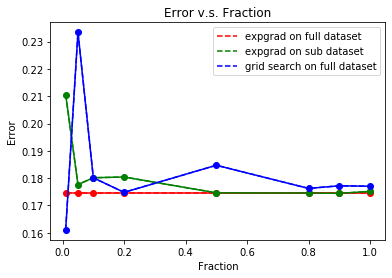

In [16]:
l1 = plt.plot(fractions,error_expgrad_alls,'r--',label="expgrad on full dataset")
l2 = plt.plot(fractions,error_expgrad_fracs,'g--',label="expgrad on sub dataset")
l3 = plt.plot(fractions,error_grids,'b--',label="grid search on full dataset")
plt.plot(fractions,error_expgrad_alls,'ro-',fractions,error_expgrad_fracs,'go-',fractions,error_grids,'bo-')
plt.xlabel('Fraction')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.legend()
plt.show()

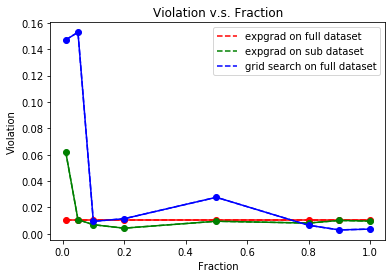

In [17]:
l1 = plt.plot(fractions,vio_expgrad_alls,'r--',label="expgrad on full dataset")
l2 = plt.plot(fractions,vio_expgrad_fracs,'g--',label="expgrad on sub dataset")
l3 = plt.plot(fractions,vio_grids,'b--',label="grid search on full dataset")
plt.plot(fractions,vio_expgrad_alls,'ro-',fractions,vio_expgrad_fracs,'go-',fractions,vio_grids,'bo-')
plt.xlabel('Fraction')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.legend()
plt.show()